In [1]:
!pip install xgboost

     -------------------------------------- 125.4/125.4 MB 7.0 MB/s eta 0:00:00


In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

In [12]:
print(xgb.__version__)

1.6.2


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test , pred, pred_proba):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


### 사이킷런 Wrapper XGBoost 개요 및 적용 
Boosting 이란?
- 여러 개의 약한 의사결정나무(Decision Tree)를 조합해서 사용하는 앙상블(Ensemble) 기법 중 하나
즉, 약한 예측 모형들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측모형을 만든다.

XGBoost 란?
- XGBoost는 Extreme Gradient Boosting의 약자이다. 해석하면 극한 변화도(경사도) 부스팅
- Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost 가 대표적
- 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost 이다.
- Regression, Classification 문제를 모두 지원하며, 성능과 자원 효율이 좋아서, 인기 있게 사용되는 알고리즘 이다.

XGBoost의 장점
- GBM 대비 빠른 수행시간
- 병렬 처리로 학습, 분류 속도가 빠르다.
- 과적합 규제(Regularization)
- 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성 지닌다.
- 분류와 회귀영역에서 뛰어난 예측 성능 발휘
- 즉, CART(Classification and regression tree) 앙상블 모델을 사용
- Early Stopping(조기 종료) 기능이 있음
- 다양한 옵션을 제공하며 Customizing이 용이하다.
- Missing Values : 결측치를 내부적으로 처리해준다. 실제로 kaggle에 적용해보는 과정에서 편리함


In [13]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
print(dataset.target_names)
cancer_df.target.value_counts()

# 악성 > 양성

['malignant' 'benign']


1    357
0    212
Name: target, dtype: int64

In [4]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [16]:
#위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습, 10%는 검증용 데이터로 분리

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)
print(X_tr.shape, X_val.shape)

(409, 30) (46, 30)


## 파이썬 래퍼 XGBoost 적용

In [17]:
#학습, 검증, 테스트용 DMatrix 설정
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [18]:
params = {'max_depth':3,
         'eta': 0.05,
         'objective':'binary:logistic',
         'eval_metric':'logloss'}
num_rounds = 400

In [19]:
eval_list = [(dval, 'eval')]

#하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달 
#학습이 완료된 모델 객체 반환
xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, early_stopping_rounds=50, evals=eval_list)


# [126]	eval-logloss:0.25587 에 가장 성능이 좋은데, 조기 중단할수있는 최소 반복횟수인 50회동안 더 했는데도
#126이 가장 작았기때문에 50회 최소 반복하고 176번에서 끝난것 

[0]	eval-logloss:0.66183
[1]	eval-logloss:0.63609
[2]	eval-logloss:0.61144
[3]	eval-logloss:0.59204
[4]	eval-logloss:0.57329
[5]	eval-logloss:0.55037
[6]	eval-logloss:0.52930
[7]	eval-logloss:0.51534
[8]	eval-logloss:0.49718
[9]	eval-logloss:0.48154
[10]	eval-logloss:0.46990
[11]	eval-logloss:0.45474
[12]	eval-logloss:0.44229
[13]	eval-logloss:0.42961
[14]	eval-logloss:0.42065
[15]	eval-logloss:0.40958
[16]	eval-logloss:0.39887
[17]	eval-logloss:0.39050
[18]	eval-logloss:0.38254
[19]	eval-logloss:0.37393
[20]	eval-logloss:0.36789
[21]	eval-logloss:0.36017
[22]	eval-logloss:0.35421
[23]	eval-logloss:0.34683
[24]	eval-logloss:0.34111
[25]	eval-logloss:0.33634
[26]	eval-logloss:0.33082
[27]	eval-logloss:0.32675
[28]	eval-logloss:0.32099
[29]	eval-logloss:0.31671
[30]	eval-logloss:0.31277
[31]	eval-logloss:0.30882
[32]	eval-logloss:0.30437
[33]	eval-logloss:0.30103
[34]	eval-logloss:0.29794
[35]	eval-logloss:0.29499
[36]	eval-logloss:0.29295
[37]	eval-logloss:0.29043
[38]	eval-logloss:0.28

In [20]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x> 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [23]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


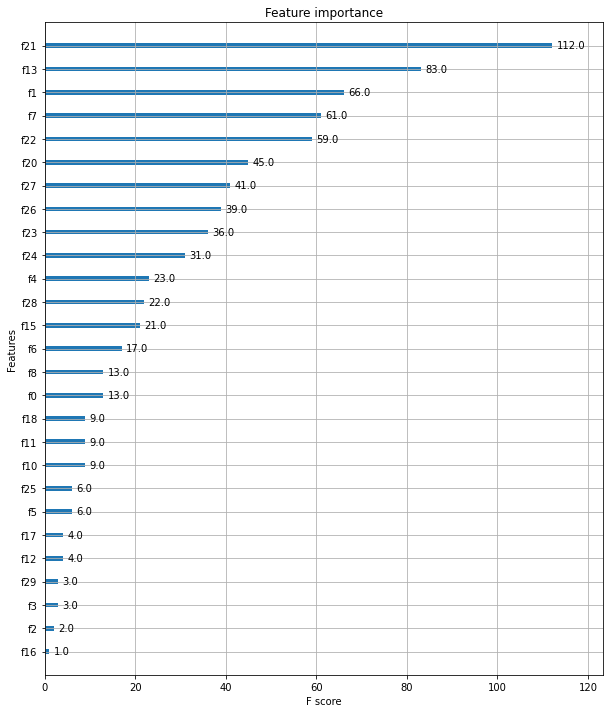

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
xgb.plot_importance(xgb_model, ax=ax)

# tif - 고화질 그래픽 형식으로 저장된 이미지 파일
# dpi (Dots per Inch)는 이미지의 해상도를 설정
# bbox_inches는 그래프로 저장할 영역을 설정합니다.디폴트로 None, tight’로 지정하면 여백을 최소화하고 그래프 영역만 이미지로 저장
plt.savefig('p239_xgb_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

## 사이킷런 래퍼 XGBoost의 개요 및 적용

In [27]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [28]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [31]:
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)

evals = [(X_tr,y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=50, eval_set=evals, eval_metric='logloss',verbose=True)
ws50_preds = xgb_wrapper.predict(X_test)
ws50_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.60896	validation_1-logloss:0.61619
[1]	validation_0-logloss:0.53953	validation_1-logloss:0.55215
[2]	validation_0-logloss:0.48154	validation_1-logloss:0.50343
[3]	validation_0-logloss:0.43183	validation_1-logloss:0.45784
[4]	validation_0-logloss:0.38681	validation_1-logloss:0.42380
[5]	validation_0-logloss:0.35016	validation_1-logloss:0.38962
[6]	validation_0-logloss:0.31677	validation_1-logloss:0.36081
[7]	validation_0-logloss:0.28774	validation_1-logloss:0.33571
[8]	validation_0-logloss:0.26261	validation_1-logloss:0.31061
[9]	validation_0-logloss:0.24001	validation_1-logloss:0.29086
[10]	validation_0-logloss:0.22048	validation_1-logloss:0.27208
[11]	validation_0-logloss:0.20262	validation_1-logloss:0.25518
[12]	validation_0-logloss:0.18669	validation_1-logloss:0.24101
[13]	validation_0-logloss:0.17236	validation_1-logloss:0.22730
[14]	validation_0-logloss:0.15975	validation_1-logloss:0.21384
[15]	validation_0-logloss:0.14821	validation_1-logloss:0.20171
[1

[130]	validation_0-logloss:0.00763	validation_1-logloss:0.01588
[131]	validation_0-logloss:0.00759	validation_1-logloss:0.01572
[132]	validation_0-logloss:0.00756	validation_1-logloss:0.01568
[133]	validation_0-logloss:0.00749	validation_1-logloss:0.01548
[134]	validation_0-logloss:0.00746	validation_1-logloss:0.01551
[135]	validation_0-logloss:0.00742	validation_1-logloss:0.01535
[136]	validation_0-logloss:0.00735	validation_1-logloss:0.01535
[137]	validation_0-logloss:0.00728	validation_1-logloss:0.01511
[138]	validation_0-logloss:0.00726	validation_1-logloss:0.01501
[139]	validation_0-logloss:0.00720	validation_1-logloss:0.01485
[140]	validation_0-logloss:0.00717	validation_1-logloss:0.01488
[141]	validation_0-logloss:0.00713	validation_1-logloss:0.01473
[142]	validation_0-logloss:0.00711	validation_1-logloss:0.01464
[143]	validation_0-logloss:0.00709	validation_1-logloss:0.01460
[144]	validation_0-logloss:0.00703	validation_1-logloss:0.01440
[145]	validation_0-logloss:0.00700	valid

[259]	validation_0-logloss:0.00532	validation_1-logloss:0.01072
[260]	validation_0-logloss:0.00531	validation_1-logloss:0.01074
[261]	validation_0-logloss:0.00530	validation_1-logloss:0.01070
[262]	validation_0-logloss:0.00529	validation_1-logloss:0.01065
[263]	validation_0-logloss:0.00529	validation_1-logloss:0.01065
[264]	validation_0-logloss:0.00528	validation_1-logloss:0.01063
[265]	validation_0-logloss:0.00527	validation_1-logloss:0.01056
[266]	validation_0-logloss:0.00526	validation_1-logloss:0.01056
[267]	validation_0-logloss:0.00525	validation_1-logloss:0.01058
[268]	validation_0-logloss:0.00525	validation_1-logloss:0.01055
[269]	validation_0-logloss:0.00523	validation_1-logloss:0.01056
[270]	validation_0-logloss:0.00523	validation_1-logloss:0.01050
[271]	validation_0-logloss:0.00522	validation_1-logloss:0.01050
[272]	validation_0-logloss:0.00521	validation_1-logloss:0.01050
[273]	validation_0-logloss:0.00520	validation_1-logloss:0.01049
[274]	validation_0-logloss:0.00520	valid

[388]	validation_0-logloss:0.00459	validation_1-logloss:0.00900
[389]	validation_0-logloss:0.00459	validation_1-logloss:0.00895
[390]	validation_0-logloss:0.00458	validation_1-logloss:0.00895
[391]	validation_0-logloss:0.00458	validation_1-logloss:0.00892
[392]	validation_0-logloss:0.00458	validation_1-logloss:0.00892
[393]	validation_0-logloss:0.00457	validation_1-logloss:0.00892
[394]	validation_0-logloss:0.00457	validation_1-logloss:0.00892
[395]	validation_0-logloss:0.00457	validation_1-logloss:0.00889
[396]	validation_0-logloss:0.00456	validation_1-logloss:0.00889
[397]	validation_0-logloss:0.00456	validation_1-logloss:0.00889
[398]	validation_0-logloss:0.00456	validation_1-logloss:0.00885
[399]	validation_0-logloss:0.00455	validation_1-logloss:0.00885


In [32]:
get_clf_eval(y_test , ws50_preds, ws50_preds_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [33]:
# early_stopping_rounds=10으로 설정 후 재학습


xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_set=evals, eval_metric='logloss',verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test , ws10_preds, ws10_preds_proba)

[0]	validation_0-logloss:0.60896	validation_1-logloss:0.61619
[1]	validation_0-logloss:0.53953	validation_1-logloss:0.55215
[2]	validation_0-logloss:0.48154	validation_1-logloss:0.50343
[3]	validation_0-logloss:0.43183	validation_1-logloss:0.45784
[4]	validation_0-logloss:0.38681	validation_1-logloss:0.42380
[5]	validation_0-logloss:0.35016	validation_1-logloss:0.38962
[6]	validation_0-logloss:0.31677	validation_1-logloss:0.36081
[7]	validation_0-logloss:0.28774	validation_1-logloss:0.33571
[8]	validation_0-logloss:0.26261	validation_1-logloss:0.31061
[9]	validation_0-logloss:0.24001	validation_1-logloss:0.29086
[10]	validation_0-logloss:0.22048	validation_1-logloss:0.27208
[11]	validation_0-logloss:0.20262	validation_1-logloss:0.25518
[12]	validation_0-logloss:0.18669	validation_1-logloss:0.24101
[13]	validation_0-logloss:0.17236	validation_1-logloss:0.22730
[14]	validation_0-logloss:0.15975	validation_1-logloss:0.21384
[15]	validation_0-logloss:0.14821	validation_1-logloss:0.20171
[1

[130]	validation_0-logloss:0.00763	validation_1-logloss:0.01588
[131]	validation_0-logloss:0.00759	validation_1-logloss:0.01572
[132]	validation_0-logloss:0.00756	validation_1-logloss:0.01568
[133]	validation_0-logloss:0.00749	validation_1-logloss:0.01548
[134]	validation_0-logloss:0.00746	validation_1-logloss:0.01551
[135]	validation_0-logloss:0.00742	validation_1-logloss:0.01535
[136]	validation_0-logloss:0.00735	validation_1-logloss:0.01535
[137]	validation_0-logloss:0.00728	validation_1-logloss:0.01511
[138]	validation_0-logloss:0.00726	validation_1-logloss:0.01501
[139]	validation_0-logloss:0.00720	validation_1-logloss:0.01485
[140]	validation_0-logloss:0.00717	validation_1-logloss:0.01488
[141]	validation_0-logloss:0.00713	validation_1-logloss:0.01473
[142]	validation_0-logloss:0.00711	validation_1-logloss:0.01464
[143]	validation_0-logloss:0.00709	validation_1-logloss:0.01460
[144]	validation_0-logloss:0.00703	validation_1-logloss:0.01440
[145]	validation_0-logloss:0.00700	valid

[259]	validation_0-logloss:0.00532	validation_1-logloss:0.01072
[260]	validation_0-logloss:0.00531	validation_1-logloss:0.01074
[261]	validation_0-logloss:0.00530	validation_1-logloss:0.01070
[262]	validation_0-logloss:0.00529	validation_1-logloss:0.01065
[263]	validation_0-logloss:0.00529	validation_1-logloss:0.01065
[264]	validation_0-logloss:0.00528	validation_1-logloss:0.01063
[265]	validation_0-logloss:0.00527	validation_1-logloss:0.01056
[266]	validation_0-logloss:0.00526	validation_1-logloss:0.01056
[267]	validation_0-logloss:0.00525	validation_1-logloss:0.01058
[268]	validation_0-logloss:0.00525	validation_1-logloss:0.01055
[269]	validation_0-logloss:0.00523	validation_1-logloss:0.01056
[270]	validation_0-logloss:0.00523	validation_1-logloss:0.01050
[271]	validation_0-logloss:0.00522	validation_1-logloss:0.01050
[272]	validation_0-logloss:0.00521	validation_1-logloss:0.01050
[273]	validation_0-logloss:0.00520	validation_1-logloss:0.01049
[274]	validation_0-logloss:0.00520	valid

[388]	validation_0-logloss:0.00459	validation_1-logloss:0.00900
[389]	validation_0-logloss:0.00459	validation_1-logloss:0.00895
[390]	validation_0-logloss:0.00458	validation_1-logloss:0.00895
[391]	validation_0-logloss:0.00458	validation_1-logloss:0.00892
[392]	validation_0-logloss:0.00458	validation_1-logloss:0.00892
[393]	validation_0-logloss:0.00457	validation_1-logloss:0.00892
[394]	validation_0-logloss:0.00457	validation_1-logloss:0.00892
[395]	validation_0-logloss:0.00457	validation_1-logloss:0.00889
[396]	validation_0-logloss:0.00456	validation_1-logloss:0.00889
[397]	validation_0-logloss:0.00456	validation_1-logloss:0.00889
[398]	validation_0-logloss:0.00456	validation_1-logloss:0.00885
[399]	validation_0-logloss:0.00455	validation_1-logloss:0.00885
오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

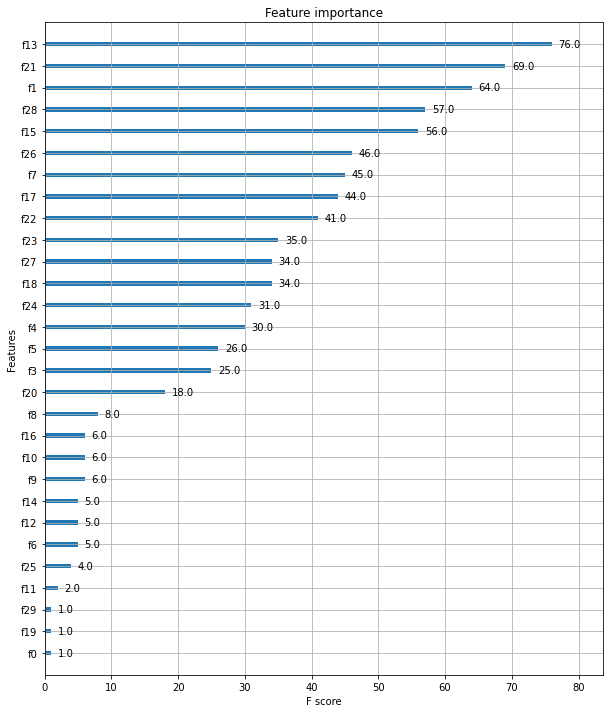

In [34]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)

### 왜 새로운 코드랑 강사님은 evals를 저렇게 했는지, 왜 내 위에 코드들은 early_stopping_rounds가 적용 x?

In [11]:

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test,y_test)]

xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=400, eval_set=evals, eval_metric='logloss',verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [12]:
get_clf_eval(y_test, w_preds, w_preds_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [14]:
# 211번에서 311번까지 반복동안 성능 평가 지수가 향샹되지 않으므로 stop(early_stopping_rounds=100)
from xgboost import XGBClassifier
evals = [(X_test,y_test)]
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_set=evals, eval_metric='logloss',verbose=True)
w100_preds = xgb_wrapper.predict(X_test)
w100_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [15]:
get_clf_eval(y_test,w100_preds,w100_preds_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

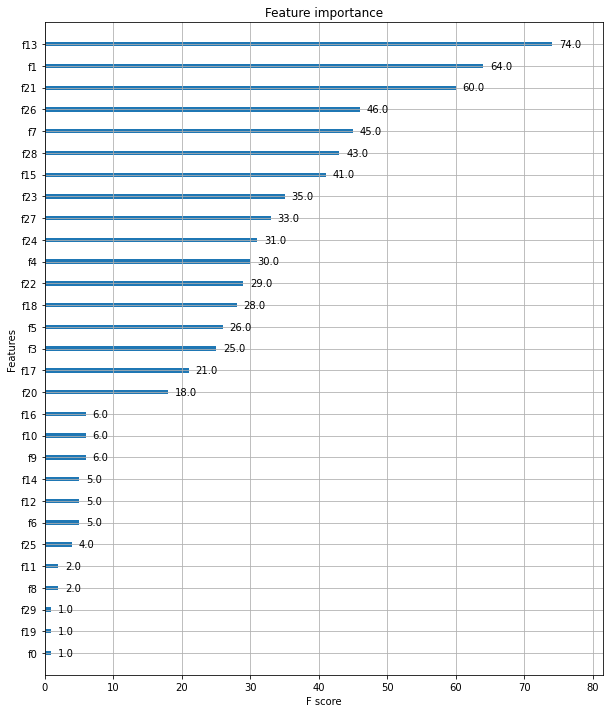

In [16]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper,ax=ax)

## LightGBM

In [36]:
!pip install lightgbm

### 위스콘신 유방암 예시

과제_0921_3.

LightGBM을 이용하여 위스콘신 유방암 모델을 생성하고 평가 및 변수 중요도를 시각화하세요.

## [도전 과제] 캐글 산탄데르 고객 만족 예측 분석을 수행하세요.

참고 : https://www.kaggle.com/competitions/santander-customer-satisfaction/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('train_santander.csv', encoding='latin-1')
print(cust_df.shape)
cust_df.head()

(76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
cust_df.TARGET.value_counts()
unsatisfied_cnt = cust_df[cust_df.TARGET==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
unsatisfied_cnt/total_cnt

0.0395685345961589

In [5]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [6]:
cust_df.var3.value_counts()[:10]

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64

In [7]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df.var3.replace(-999999, 2, inplace=True)
cust_df.drop('ID',axis=1, inplace=True)

X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
X_features.shape

(76020, 369)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features,y_labels,test_size=0.2,random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()

print('학습데이터:\n', y_train.value_counts()/train_cnt)
print()
print('테스트데이터:\n', y_test.value_counts()/test_cnt)

학습데이터:
 0    0.960964
1    0.039036
Name: TARGET, dtype: float64

테스트데이터:
 0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [20]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

lgbm_clf = LGBMClassifier(n_estimators=500)
evals = [(X_test,y_test)]
lgbm_clf.fit(X_train,y_train,early_stopping_rounds=100,eval_metric="auc",eval_set=evals,verbose=False)
lgbm_roc_score = roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print(f'ROC AUC:{round(lgbm_roc_score,4)}')

ROC AUC:0.8409


In [21]:
from sklearn.model_selection import GridSearchCV

lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train,y_train,early_stopping_rounds=30, eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)])
print(f'최적 파라미터: {gridcv.best_params_}')
lgbm_roc_score = roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1], average='macro')
print(f'ROC AUC:{round(lgbm_roc_score,4)}')

[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
[2]	valid_0's auc: 0.82966	valid_0's binary_logloss: 0.150925	valid_1's auc: 0.826326	valid_1's binary_logloss: 0.159774
[3]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826852	valid_1's binary_logloss: 0.156113
[4]	valid_0's auc: 0.83904	valid_0's binary_logloss: 0.144173	valid_1's auc: 0.831417	valid_1's binary_logloss: 0.153186
[5]	valid_0's auc: 0.841964	valid_0's binary_logloss: 0.141745	valid_1's auc: 0.834593	valid_1's binary_logloss: 0.150797
[6]	valid_0's auc: 0.845253	valid_0's binary_logloss: 0.139712	valid_1's auc: 0.836659	valid_1's binary_logloss: 0.149062
[7]	valid_0's auc: 0.846545	valid_0's binary_logloss: 0.138053	valid_1's auc: 0.836148	valid_1's binary_logloss: 0.147537
[8]	valid_0's auc: 0.848885	valid_0's binary_logloss: 0.1366	valid_1's auc: 0.838153	valid_1's binary_logloss: 0.146268
[9]	valid_0's auc: 0.850839	v

[27]	valid_0's auc: 0.873971	valid_0's binary_logloss: 0.124767	valid_1's auc: 0.836733	valid_1's binary_logloss: 0.140247
[28]	valid_0's auc: 0.875129	valid_0's binary_logloss: 0.124434	valid_1's auc: 0.837012	valid_1's binary_logloss: 0.140143
[29]	valid_0's auc: 0.875873	valid_0's binary_logloss: 0.12414	valid_1's auc: 0.836866	valid_1's binary_logloss: 0.140163
[30]	valid_0's auc: 0.876465	valid_0's binary_logloss: 0.123865	valid_1's auc: 0.836337	valid_1's binary_logloss: 0.140195
[31]	valid_0's auc: 0.877699	valid_0's binary_logloss: 0.123521	valid_1's auc: 0.836229	valid_1's binary_logloss: 0.140186
[32]	valid_0's auc: 0.878492	valid_0's binary_logloss: 0.123253	valid_1's auc: 0.836388	valid_1's binary_logloss: 0.140145
[33]	valid_0's auc: 0.879281	valid_0's binary_logloss: 0.122981	valid_1's auc: 0.836061	valid_1's binary_logloss: 0.140165
[34]	valid_0's auc: 0.880016	valid_0's binary_logloss: 0.12271	valid_1's auc: 0.836238	valid_1's binary_logloss: 0.140112
[35]	valid_0's auc

[22]	valid_0's auc: 0.869367	valid_0's binary_logloss: 0.126428	valid_1's auc: 0.839045	valid_1's binary_logloss: 0.140242
[23]	valid_0's auc: 0.870018	valid_0's binary_logloss: 0.126051	valid_1's auc: 0.838851	valid_1's binary_logloss: 0.140113
[24]	valid_0's auc: 0.871076	valid_0's binary_logloss: 0.125665	valid_1's auc: 0.838918	valid_1's binary_logloss: 0.139963
[25]	valid_0's auc: 0.871808	valid_0's binary_logloss: 0.12529	valid_1's auc: 0.838876	valid_1's binary_logloss: 0.139886
[26]	valid_0's auc: 0.872679	valid_0's binary_logloss: 0.124953	valid_1's auc: 0.838853	valid_1's binary_logloss: 0.139811
[27]	valid_0's auc: 0.873565	valid_0's binary_logloss: 0.124623	valid_1's auc: 0.838679	valid_1's binary_logloss: 0.139786
[28]	valid_0's auc: 0.874397	valid_0's binary_logloss: 0.124307	valid_1's auc: 0.83805	valid_1's binary_logloss: 0.139815
[29]	valid_0's auc: 0.87544	valid_0's binary_logloss: 0.124018	valid_1's auc: 0.837719	valid_1's binary_logloss: 0.139819
[30]	valid_0's auc:

[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
[2]	valid_0's auc: 0.82966	valid_0's binary_logloss: 0.150925	valid_1's auc: 0.826326	valid_1's binary_logloss: 0.159774
[3]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826852	valid_1's binary_logloss: 0.156113
[4]	valid_0's auc: 0.83904	valid_0's binary_logloss: 0.144173	valid_1's auc: 0.831417	valid_1's binary_logloss: 0.153186
[5]	valid_0's auc: 0.841964	valid_0's binary_logloss: 0.141745	valid_1's auc: 0.834593	valid_1's binary_logloss: 0.150797
[6]	valid_0's auc: 0.845253	valid_0's binary_logloss: 0.139712	valid_1's auc: 0.836659	valid_1's binary_logloss: 0.149062
[7]	valid_0's auc: 0.846545	valid_0's binary_logloss: 0.138053	valid_1's auc: 0.836148	valid_1's binary_logloss: 0.147537
[8]	valid_0's auc: 0.848885	valid_0's binary_logloss: 0.1366	valid_1's auc: 0.838153	valid_1's binary_logloss: 0.146268
[9]	valid_0's auc: 0.850839	v

[38]	valid_0's auc: 0.883018	valid_0's binary_logloss: 0.121618	valid_1's auc: 0.836863	valid_1's binary_logloss: 0.139968
[39]	valid_0's auc: 0.883857	valid_0's binary_logloss: 0.12136	valid_1's auc: 0.837075	valid_1's binary_logloss: 0.139959
[40]	valid_0's auc: 0.884437	valid_0's binary_logloss: 0.121112	valid_1's auc: 0.836834	valid_1's binary_logloss: 0.139996
[1]	valid_0's auc: 0.825972	valid_0's binary_logloss: 0.15626	valid_1's auc: 0.817426	valid_1's binary_logloss: 0.165002
[2]	valid_0's auc: 0.830735	valid_0's binary_logloss: 0.150869	valid_1's auc: 0.821832	valid_1's binary_logloss: 0.159685
[3]	valid_0's auc: 0.836213	valid_0's binary_logloss: 0.147022	valid_1's auc: 0.825847	valid_1's binary_logloss: 0.156023
[4]	valid_0's auc: 0.839911	valid_0's binary_logloss: 0.143985	valid_1's auc: 0.830159	valid_1's binary_logloss: 0.153298
[5]	valid_0's auc: 0.842712	valid_0's binary_logloss: 0.14152	valid_1's auc: 0.831253	valid_1's binary_logloss: 0.151107
[6]	valid_0's auc: 0.845

[1]	valid_0's auc: 0.823422	valid_0's binary_logloss: 0.156446	valid_1's auc: 0.819043	valid_1's binary_logloss: 0.165337
[2]	valid_0's auc: 0.830391	valid_0's binary_logloss: 0.151103	valid_1's auc: 0.82466	valid_1's binary_logloss: 0.160151
[3]	valid_0's auc: 0.836251	valid_0's binary_logloss: 0.14724	valid_1's auc: 0.829717	valid_1's binary_logloss: 0.156452
[4]	valid_0's auc: 0.842516	valid_0's binary_logloss: 0.144162	valid_1's auc: 0.832695	valid_1's binary_logloss: 0.15358
[5]	valid_0's auc: 0.846316	valid_0's binary_logloss: 0.141636	valid_1's auc: 0.834705	valid_1's binary_logloss: 0.151246
[6]	valid_0's auc: 0.847998	valid_0's binary_logloss: 0.139517	valid_1's auc: 0.836546	valid_1's binary_logloss: 0.149374
[7]	valid_0's auc: 0.849074	valid_0's binary_logloss: 0.13782	valid_1's auc: 0.838333	valid_1's binary_logloss: 0.147794
[8]	valid_0's auc: 0.85	valid_0's binary_logloss: 0.136391	valid_1's auc: 0.838986	valid_1's binary_logloss: 0.146497
[9]	valid_0's auc: 0.851546	vali

[20]	valid_0's auc: 0.885553	valid_0's binary_logloss: 0.121835	valid_1's auc: 0.837335	valid_1's binary_logloss: 0.140578
[21]	valid_0's auc: 0.886758	valid_0's binary_logloss: 0.121199	valid_1's auc: 0.837053	valid_1's binary_logloss: 0.1405
[22]	valid_0's auc: 0.888245	valid_0's binary_logloss: 0.120566	valid_1's auc: 0.837133	valid_1's binary_logloss: 0.140423
[23]	valid_0's auc: 0.889287	valid_0's binary_logloss: 0.119999	valid_1's auc: 0.837039	valid_1's binary_logloss: 0.140319
[24]	valid_0's auc: 0.890242	valid_0's binary_logloss: 0.119535	valid_1's auc: 0.837226	valid_1's binary_logloss: 0.140192
[25]	valid_0's auc: 0.89128	valid_0's binary_logloss: 0.119025	valid_1's auc: 0.836975	valid_1's binary_logloss: 0.140152
[26]	valid_0's auc: 0.892936	valid_0's binary_logloss: 0.118515	valid_1's auc: 0.836466	valid_1's binary_logloss: 0.14011
[27]	valid_0's auc: 0.894014	valid_0's binary_logloss: 0.118046	valid_1's auc: 0.835957	valid_1's binary_logloss: 0.140163
[28]	valid_0's auc: 

[21]	valid_0's auc: 0.886788	valid_0's binary_logloss: 0.120948	valid_1's auc: 0.83734	valid_1's binary_logloss: 0.139793
[22]	valid_0's auc: 0.888424	valid_0's binary_logloss: 0.120314	valid_1's auc: 0.83802	valid_1's binary_logloss: 0.139623
[23]	valid_0's auc: 0.889756	valid_0's binary_logloss: 0.119797	valid_1's auc: 0.837015	valid_1's binary_logloss: 0.139653
[24]	valid_0's auc: 0.891304	valid_0's binary_logloss: 0.119202	valid_1's auc: 0.837202	valid_1's binary_logloss: 0.139584
[25]	valid_0's auc: 0.892545	valid_0's binary_logloss: 0.118664	valid_1's auc: 0.837268	valid_1's binary_logloss: 0.1395
[26]	valid_0's auc: 0.893944	valid_0's binary_logloss: 0.118169	valid_1's auc: 0.837371	valid_1's binary_logloss: 0.139458
[27]	valid_0's auc: 0.894982	valid_0's binary_logloss: 0.117651	valid_1's auc: 0.836907	valid_1's binary_logloss: 0.139528
[28]	valid_0's auc: 0.896304	valid_0's binary_logloss: 0.117168	valid_1's auc: 0.837127	valid_1's binary_logloss: 0.139491
[29]	valid_0's auc: 

[1]	valid_0's auc: 0.833594	valid_0's binary_logloss: 0.155635	valid_1's auc: 0.820913	valid_1's binary_logloss: 0.165016
[2]	valid_0's auc: 0.846048	valid_0's binary_logloss: 0.149713	valid_1's auc: 0.830646	valid_1's binary_logloss: 0.159607
[3]	valid_0's auc: 0.849539	valid_0's binary_logloss: 0.145369	valid_1's auc: 0.833531	valid_1's binary_logloss: 0.155847
[4]	valid_0's auc: 0.8529	valid_0's binary_logloss: 0.142095	valid_1's auc: 0.832813	valid_1's binary_logloss: 0.15325
[5]	valid_0's auc: 0.855497	valid_0's binary_logloss: 0.13934	valid_1's auc: 0.833555	valid_1's binary_logloss: 0.150958
[6]	valid_0's auc: 0.860603	valid_0's binary_logloss: 0.13707	valid_1's auc: 0.836476	valid_1's binary_logloss: 0.149037
[7]	valid_0's auc: 0.86401	valid_0's binary_logloss: 0.13507	valid_1's auc: 0.838639	valid_1's binary_logloss: 0.147363
[8]	valid_0's auc: 0.866327	valid_0's binary_logloss: 0.133353	valid_1's auc: 0.83917	valid_1's binary_logloss: 0.146142
[9]	valid_0's auc: 0.868666	vali

[32]	valid_0's auc: 0.899428	valid_0's binary_logloss: 0.115755	valid_1's auc: 0.836228	valid_1's binary_logloss: 0.139825
[33]	valid_0's auc: 0.900129	valid_0's binary_logloss: 0.115374	valid_1's auc: 0.836132	valid_1's binary_logloss: 0.139815
[34]	valid_0's auc: 0.900819	valid_0's binary_logloss: 0.115047	valid_1's auc: 0.836189	valid_1's binary_logloss: 0.139786
[35]	valid_0's auc: 0.901929	valid_0's binary_logloss: 0.114682	valid_1's auc: 0.836241	valid_1's binary_logloss: 0.139758
[36]	valid_0's auc: 0.902923	valid_0's binary_logloss: 0.114287	valid_1's auc: 0.836594	valid_1's binary_logloss: 0.139739
[37]	valid_0's auc: 0.903583	valid_0's binary_logloss: 0.113893	valid_1's auc: 0.836319	valid_1's binary_logloss: 0.139831
[38]	valid_0's auc: 0.904289	valid_0's binary_logloss: 0.113536	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.139874
[39]	valid_0's auc: 0.904948	valid_0's binary_logloss: 0.113207	valid_1's auc: 0.835797	valid_1's binary_logloss: 0.139959
[40]	valid_0's a

[20]	valid_0's auc: 0.88564	valid_0's binary_logloss: 0.121562	valid_1's auc: 0.836976	valid_1's binary_logloss: 0.139982
[21]	valid_0's auc: 0.886788	valid_0's binary_logloss: 0.120948	valid_1's auc: 0.83734	valid_1's binary_logloss: 0.139793
[22]	valid_0's auc: 0.888424	valid_0's binary_logloss: 0.120314	valid_1's auc: 0.83802	valid_1's binary_logloss: 0.139623
[23]	valid_0's auc: 0.889756	valid_0's binary_logloss: 0.119797	valid_1's auc: 0.837015	valid_1's binary_logloss: 0.139653
[24]	valid_0's auc: 0.891304	valid_0's binary_logloss: 0.119202	valid_1's auc: 0.837202	valid_1's binary_logloss: 0.139584
[25]	valid_0's auc: 0.892545	valid_0's binary_logloss: 0.118664	valid_1's auc: 0.837268	valid_1's binary_logloss: 0.1395
[26]	valid_0's auc: 0.893944	valid_0's binary_logloss: 0.118169	valid_1's auc: 0.837371	valid_1's binary_logloss: 0.139458
[27]	valid_0's auc: 0.894982	valid_0's binary_logloss: 0.117651	valid_1's auc: 0.836907	valid_1's binary_logloss: 0.139528
[28]	valid_0's auc: 0

[1]	valid_0's auc: 0.833594	valid_0's binary_logloss: 0.155635	valid_1's auc: 0.820913	valid_1's binary_logloss: 0.165016
[2]	valid_0's auc: 0.846048	valid_0's binary_logloss: 0.149713	valid_1's auc: 0.830646	valid_1's binary_logloss: 0.159607
[3]	valid_0's auc: 0.849539	valid_0's binary_logloss: 0.145369	valid_1's auc: 0.833531	valid_1's binary_logloss: 0.155847
[4]	valid_0's auc: 0.8529	valid_0's binary_logloss: 0.142095	valid_1's auc: 0.832813	valid_1's binary_logloss: 0.15325
[5]	valid_0's auc: 0.855497	valid_0's binary_logloss: 0.13934	valid_1's auc: 0.833555	valid_1's binary_logloss: 0.150958
[6]	valid_0's auc: 0.860603	valid_0's binary_logloss: 0.13707	valid_1's auc: 0.836476	valid_1's binary_logloss: 0.149037
[7]	valid_0's auc: 0.86401	valid_0's binary_logloss: 0.13507	valid_1's auc: 0.838639	valid_1's binary_logloss: 0.147363
[8]	valid_0's auc: 0.866327	valid_0's binary_logloss: 0.133353	valid_1's auc: 0.83917	valid_1's binary_logloss: 0.146142
[9]	valid_0's auc: 0.868666	vali

[28]	valid_0's auc: 0.874911	valid_0's binary_logloss: 0.124675	valid_1's auc: 0.836489	valid_1's binary_logloss: 0.139742
[29]	valid_0's auc: 0.875538	valid_0's binary_logloss: 0.124397	valid_1's auc: 0.836554	valid_1's binary_logloss: 0.139712
[30]	valid_0's auc: 0.876317	valid_0's binary_logloss: 0.124137	valid_1's auc: 0.836181	valid_1's binary_logloss: 0.139716
[31]	valid_0's auc: 0.87724	valid_0's binary_logloss: 0.123841	valid_1's auc: 0.836284	valid_1's binary_logloss: 0.139683
[32]	valid_0's auc: 0.877783	valid_0's binary_logloss: 0.123594	valid_1's auc: 0.835851	valid_1's binary_logloss: 0.139729
[33]	valid_0's auc: 0.878348	valid_0's binary_logloss: 0.12338	valid_1's auc: 0.835408	valid_1's binary_logloss: 0.139824
[34]	valid_0's auc: 0.878909	valid_0's binary_logloss: 0.123136	valid_1's auc: 0.835474	valid_1's binary_logloss: 0.139745
[35]	valid_0's auc: 0.879757	valid_0's binary_logloss: 0.122828	valid_1's auc: 0.835337	valid_1's binary_logloss: 0.139761
[36]	valid_0's auc

[26]	valid_0's auc: 0.871934	valid_0's binary_logloss: 0.12537	valid_1's auc: 0.838594	valid_1's binary_logloss: 0.139669
[27]	valid_0's auc: 0.873048	valid_0's binary_logloss: 0.125049	valid_1's auc: 0.83847	valid_1's binary_logloss: 0.139655
[28]	valid_0's auc: 0.873824	valid_0's binary_logloss: 0.124767	valid_1's auc: 0.838229	valid_1's binary_logloss: 0.139655
[29]	valid_0's auc: 0.874662	valid_0's binary_logloss: 0.124467	valid_1's auc: 0.838445	valid_1's binary_logloss: 0.139579
[30]	valid_0's auc: 0.87542	valid_0's binary_logloss: 0.124168	valid_1's auc: 0.838156	valid_1's binary_logloss: 0.139548
[31]	valid_0's auc: 0.876207	valid_0's binary_logloss: 0.123915	valid_1's auc: 0.838237	valid_1's binary_logloss: 0.139538
[32]	valid_0's auc: 0.877156	valid_0's binary_logloss: 0.123623	valid_1's auc: 0.838271	valid_1's binary_logloss: 0.13947
[33]	valid_0's auc: 0.87768	valid_0's binary_logloss: 0.12338	valid_1's auc: 0.838713	valid_1's binary_logloss: 0.139346
[34]	valid_0's auc: 0.

[1]	valid_0's auc: 0.822477	valid_0's binary_logloss: 0.156615	valid_1's auc: 0.818936	valid_1's binary_logloss: 0.16507
[2]	valid_0's auc: 0.829931	valid_0's binary_logloss: 0.151227	valid_1's auc: 0.824213	valid_1's binary_logloss: 0.159973
[3]	valid_0's auc: 0.835788	valid_0's binary_logloss: 0.147372	valid_1's auc: 0.829555	valid_1's binary_logloss: 0.156407
[4]	valid_0's auc: 0.842398	valid_0's binary_logloss: 0.14436	valid_1's auc: 0.833204	valid_1's binary_logloss: 0.153426
[5]	valid_0's auc: 0.84472	valid_0's binary_logloss: 0.141969	valid_1's auc: 0.835438	valid_1's binary_logloss: 0.15118
[6]	valid_0's auc: 0.846873	valid_0's binary_logloss: 0.13984	valid_1's auc: 0.836808	valid_1's binary_logloss: 0.149232
[7]	valid_0's auc: 0.849397	valid_0's binary_logloss: 0.138081	valid_1's auc: 0.838165	valid_1's binary_logloss: 0.147687
[8]	valid_0's auc: 0.850636	valid_0's binary_logloss: 0.136651	valid_1's auc: 0.839203	valid_1's binary_logloss: 0.146397
[9]	valid_0's auc: 0.852058	v

[75]	valid_0's auc: 0.900318	valid_0's binary_logloss: 0.115012	valid_1's auc: 0.8431	valid_1's binary_logloss: 0.138652
[76]	valid_0's auc: 0.900838	valid_0's binary_logloss: 0.114797	valid_1's auc: 0.843128	valid_1's binary_logloss: 0.138654
[77]	valid_0's auc: 0.901053	valid_0's binary_logloss: 0.11465	valid_1's auc: 0.843183	valid_1's binary_logloss: 0.138667
[78]	valid_0's auc: 0.901334	valid_0's binary_logloss: 0.114492	valid_1's auc: 0.843036	valid_1's binary_logloss: 0.138728
[1]	valid_0's auc: 0.823879	valid_0's binary_logloss: 0.156213	valid_1's auc: 0.821528	valid_1's binary_logloss: 0.16489
[2]	valid_0's auc: 0.829817	valid_0's binary_logloss: 0.151021	valid_1's auc: 0.825621	valid_1's binary_logloss: 0.159697
[3]	valid_0's auc: 0.835232	valid_0's binary_logloss: 0.147177	valid_1's auc: 0.827536	valid_1's binary_logloss: 0.156048
[4]	valid_0's auc: 0.83968	valid_0's binary_logloss: 0.144169	valid_1's auc: 0.829988	valid_1's binary_logloss: 0.15317
[5]	valid_0's auc: 0.84236

[27]	valid_0's auc: 0.872756	valid_0's binary_logloss: 0.125201	valid_1's auc: 0.837762	valid_1's binary_logloss: 0.140044
[28]	valid_0's auc: 0.874041	valid_0's binary_logloss: 0.124866	valid_1's auc: 0.837513	valid_1's binary_logloss: 0.14003
[29]	valid_0's auc: 0.875088	valid_0's binary_logloss: 0.12452	valid_1's auc: 0.837397	valid_1's binary_logloss: 0.140013
[30]	valid_0's auc: 0.876006	valid_0's binary_logloss: 0.124204	valid_1's auc: 0.837051	valid_1's binary_logloss: 0.140044
[31]	valid_0's auc: 0.876443	valid_0's binary_logloss: 0.123946	valid_1's auc: 0.837341	valid_1's binary_logloss: 0.139984
[32]	valid_0's auc: 0.877157	valid_0's binary_logloss: 0.123679	valid_1's auc: 0.837186	valid_1's binary_logloss: 0.139974
[33]	valid_0's auc: 0.877846	valid_0's binary_logloss: 0.123426	valid_1's auc: 0.836741	valid_1's binary_logloss: 0.140021
[34]	valid_0's auc: 0.879036	valid_0's binary_logloss: 0.123124	valid_1's auc: 0.836345	valid_1's binary_logloss: 0.140057
[35]	valid_0's auc

[25]	valid_0's auc: 0.869233	valid_0's binary_logloss: 0.126158	valid_1's auc: 0.840131	valid_1's binary_logloss: 0.139495
[26]	valid_0's auc: 0.870146	valid_0's binary_logloss: 0.12583	valid_1's auc: 0.839809	valid_1's binary_logloss: 0.139487
[27]	valid_0's auc: 0.871289	valid_0's binary_logloss: 0.125495	valid_1's auc: 0.83977	valid_1's binary_logloss: 0.139452
[28]	valid_0's auc: 0.872449	valid_0's binary_logloss: 0.125203	valid_1's auc: 0.839707	valid_1's binary_logloss: 0.139417
[29]	valid_0's auc: 0.87307	valid_0's binary_logloss: 0.124902	valid_1's auc: 0.840062	valid_1's binary_logloss: 0.13934
[30]	valid_0's auc: 0.874009	valid_0's binary_logloss: 0.124599	valid_1's auc: 0.839797	valid_1's binary_logloss: 0.139335
[31]	valid_0's auc: 0.874961	valid_0's binary_logloss: 0.124243	valid_1's auc: 0.839401	valid_1's binary_logloss: 0.139341
[32]	valid_0's auc: 0.875534	valid_0's binary_logloss: 0.12399	valid_1's auc: 0.839344	valid_1's binary_logloss: 0.139318
[33]	valid_0's auc: 0

[72]	valid_0's auc: 0.89933	valid_0's binary_logloss: 0.11544	valid_1's auc: 0.843123	valid_1's binary_logloss: 0.138587
[73]	valid_0's auc: 0.899665	valid_0's binary_logloss: 0.115279	valid_1's auc: 0.843158	valid_1's binary_logloss: 0.138606
[74]	valid_0's auc: 0.899872	valid_0's binary_logloss: 0.115145	valid_1's auc: 0.843153	valid_1's binary_logloss: 0.138622
[75]	valid_0's auc: 0.900318	valid_0's binary_logloss: 0.115012	valid_1's auc: 0.8431	valid_1's binary_logloss: 0.138652
[76]	valid_0's auc: 0.900838	valid_0's binary_logloss: 0.114797	valid_1's auc: 0.843128	valid_1's binary_logloss: 0.138654
[77]	valid_0's auc: 0.901053	valid_0's binary_logloss: 0.11465	valid_1's auc: 0.843183	valid_1's binary_logloss: 0.138667
[78]	valid_0's auc: 0.901334	valid_0's binary_logloss: 0.114492	valid_1's auc: 0.843036	valid_1's binary_logloss: 0.138728
[1]	valid_0's auc: 0.833136	valid_0's binary_logloss: 0.155618	valid_1's auc: 0.823516	valid_1's binary_logloss: 0.164757
[2]	valid_0's auc: 0.8

[1]	valid_0's auc: 0.834438	valid_0's binary_logloss: 0.155707	valid_1's auc: 0.821419	valid_1's binary_logloss: 0.164715
[2]	valid_0's auc: 0.845934	valid_0's binary_logloss: 0.150048	valid_1's auc: 0.831027	valid_1's binary_logloss: 0.159506
[3]	valid_0's auc: 0.849836	valid_0's binary_logloss: 0.145927	valid_1's auc: 0.831719	valid_1's binary_logloss: 0.155735
[4]	valid_0's auc: 0.854642	valid_0's binary_logloss: 0.142686	valid_1's auc: 0.835345	valid_1's binary_logloss: 0.152919
[5]	valid_0's auc: 0.856628	valid_0's binary_logloss: 0.139976	valid_1's auc: 0.83701	valid_1's binary_logloss: 0.15048
[6]	valid_0's auc: 0.859766	valid_0's binary_logloss: 0.137707	valid_1's auc: 0.83737	valid_1's binary_logloss: 0.148709
[7]	valid_0's auc: 0.861667	valid_0's binary_logloss: 0.13588	valid_1's auc: 0.837028	valid_1's binary_logloss: 0.147239
[8]	valid_0's auc: 0.863565	valid_0's binary_logloss: 0.134173	valid_1's auc: 0.838026	valid_1's binary_logloss: 0.145898
[9]	valid_0's auc: 0.866131	

[36]	valid_0's auc: 0.897535	valid_0's binary_logloss: 0.116484	valid_1's auc: 0.837261	valid_1's binary_logloss: 0.139733
[37]	valid_0's auc: 0.898253	valid_0's binary_logloss: 0.116123	valid_1's auc: 0.837235	valid_1's binary_logloss: 0.139781
[38]	valid_0's auc: 0.898964	valid_0's binary_logloss: 0.115828	valid_1's auc: 0.836835	valid_1's binary_logloss: 0.139841
[39]	valid_0's auc: 0.89972	valid_0's binary_logloss: 0.115476	valid_1's auc: 0.836629	valid_1's binary_logloss: 0.13991
[40]	valid_0's auc: 0.900293	valid_0's binary_logloss: 0.115122	valid_1's auc: 0.837147	valid_1's binary_logloss: 0.139846
[41]	valid_0's auc: 0.900934	valid_0's binary_logloss: 0.114813	valid_1's auc: 0.836986	valid_1's binary_logloss: 0.139923
[42]	valid_0's auc: 0.901636	valid_0's binary_logloss: 0.114489	valid_1's auc: 0.836537	valid_1's binary_logloss: 0.140017
[43]	valid_0's auc: 0.90272	valid_0's binary_logloss: 0.114161	valid_1's auc: 0.836588	valid_1's binary_logloss: 0.140025
[44]	valid_0's auc:

[55]	valid_0's auc: 0.912616	valid_0's binary_logloss: 0.109226	valid_1's auc: 0.837936	valid_1's binary_logloss: 0.13983
[56]	valid_0's auc: 0.913202	valid_0's binary_logloss: 0.108936	valid_1's auc: 0.83804	valid_1's binary_logloss: 0.13983
[57]	valid_0's auc: 0.913592	valid_0's binary_logloss: 0.10867	valid_1's auc: 0.838083	valid_1's binary_logloss: 0.139818
[58]	valid_0's auc: 0.913818	valid_0's binary_logloss: 0.108421	valid_1's auc: 0.837716	valid_1's binary_logloss: 0.139971
[59]	valid_0's auc: 0.914378	valid_0's binary_logloss: 0.108194	valid_1's auc: 0.837836	valid_1's binary_logloss: 0.139971
[60]	valid_0's auc: 0.91493	valid_0's binary_logloss: 0.107966	valid_1's auc: 0.837549	valid_1's binary_logloss: 0.140068
[61]	valid_0's auc: 0.915354	valid_0's binary_logloss: 0.107682	valid_1's auc: 0.837021	valid_1's binary_logloss: 0.140197
[62]	valid_0's auc: 0.915606	valid_0's binary_logloss: 0.107477	valid_1's auc: 0.836606	valid_1's binary_logloss: 0.140336
[63]	valid_0's auc: 0

[17]	valid_0's auc: 0.879493	valid_0's binary_logloss: 0.125166	valid_1's auc: 0.834462	valid_1's binary_logloss: 0.141684
[18]	valid_0's auc: 0.880697	valid_0's binary_logloss: 0.124485	valid_1's auc: 0.834855	valid_1's binary_logloss: 0.141381
[19]	valid_0's auc: 0.881751	valid_0's binary_logloss: 0.123851	valid_1's auc: 0.83548	valid_1's binary_logloss: 0.141089
[20]	valid_0's auc: 0.883208	valid_0's binary_logloss: 0.123231	valid_1's auc: 0.834617	valid_1's binary_logloss: 0.141074
[21]	valid_0's auc: 0.884441	valid_0's binary_logloss: 0.122672	valid_1's auc: 0.835086	valid_1's binary_logloss: 0.140871
[22]	valid_0's auc: 0.885795	valid_0's binary_logloss: 0.122047	valid_1's auc: 0.834691	valid_1's binary_logloss: 0.140833
[23]	valid_0's auc: 0.88703	valid_0's binary_logloss: 0.121437	valid_1's auc: 0.834867	valid_1's binary_logloss: 0.14067
[24]	valid_0's auc: 0.888628	valid_0's binary_logloss: 0.120866	valid_1's auc: 0.834703	valid_1's binary_logloss: 0.140607
[25]	valid_0's auc:

[20]	valid_0's auc: 0.88095	valid_0's binary_logloss: 0.123758	valid_1's auc: 0.839472	valid_1's binary_logloss: 0.140278
[21]	valid_0's auc: 0.882333	valid_0's binary_logloss: 0.123172	valid_1's auc: 0.839953	valid_1's binary_logloss: 0.139987
[22]	valid_0's auc: 0.883759	valid_0's binary_logloss: 0.122627	valid_1's auc: 0.840172	valid_1's binary_logloss: 0.139783
[23]	valid_0's auc: 0.884939	valid_0's binary_logloss: 0.122106	valid_1's auc: 0.840085	valid_1's binary_logloss: 0.139652
[24]	valid_0's auc: 0.886267	valid_0's binary_logloss: 0.121544	valid_1's auc: 0.839519	valid_1's binary_logloss: 0.13967
[25]	valid_0's auc: 0.887231	valid_0's binary_logloss: 0.12107	valid_1's auc: 0.839583	valid_1's binary_logloss: 0.139554
[26]	valid_0's auc: 0.888362	valid_0's binary_logloss: 0.120592	valid_1's auc: 0.839436	valid_1's binary_logloss: 0.139477
[27]	valid_0's auc: 0.889402	valid_0's binary_logloss: 0.12012	valid_1's auc: 0.839576	valid_1's binary_logloss: 0.139364
[28]	valid_0's auc: 

[35]	valid_0's auc: 0.900316	valid_0's binary_logloss: 0.115653	valid_1's auc: 0.838522	valid_1's binary_logloss: 0.13957
[36]	valid_0's auc: 0.901114	valid_0's binary_logloss: 0.11531	valid_1's auc: 0.838721	valid_1's binary_logloss: 0.139537
[37]	valid_0's auc: 0.901919	valid_0's binary_logloss: 0.114911	valid_1's auc: 0.838643	valid_1's binary_logloss: 0.139581
[38]	valid_0's auc: 0.902827	valid_0's binary_logloss: 0.114566	valid_1's auc: 0.839027	valid_1's binary_logloss: 0.139517
[39]	valid_0's auc: 0.903647	valid_0's binary_logloss: 0.114176	valid_1's auc: 0.839264	valid_1's binary_logloss: 0.13948
[40]	valid_0's auc: 0.904461	valid_0's binary_logloss: 0.11382	valid_1's auc: 0.839535	valid_1's binary_logloss: 0.13945
[41]	valid_0's auc: 0.905119	valid_0's binary_logloss: 0.113454	valid_1's auc: 0.839726	valid_1's binary_logloss: 0.139429
[42]	valid_0's auc: 0.90573	valid_0's binary_logloss: 0.11309	valid_1's auc: 0.839177	valid_1's binary_logloss: 0.139527
[43]	valid_0's auc: 0.9

[1]	valid_0's auc: 0.821268	valid_0's binary_logloss: 0.156277	valid_1's auc: 0.816814	valid_1's binary_logloss: 0.165016
[2]	valid_0's auc: 0.828863	valid_0's binary_logloss: 0.151005	valid_1's auc: 0.821376	valid_1's binary_logloss: 0.159886
[3]	valid_0's auc: 0.837474	valid_0's binary_logloss: 0.147149	valid_1's auc: 0.828229	valid_1's binary_logloss: 0.156519
[4]	valid_0's auc: 0.842962	valid_0's binary_logloss: 0.144152	valid_1's auc: 0.829952	valid_1's binary_logloss: 0.153687
[5]	valid_0's auc: 0.84635	valid_0's binary_logloss: 0.141643	valid_1's auc: 0.834055	valid_1's binary_logloss: 0.15137
[6]	valid_0's auc: 0.849269	valid_0's binary_logloss: 0.139637	valid_1's auc: 0.834861	valid_1's binary_logloss: 0.149513
[7]	valid_0's auc: 0.851069	valid_0's binary_logloss: 0.137899	valid_1's auc: 0.836696	valid_1's binary_logloss: 0.147828
[8]	valid_0's auc: 0.852425	valid_0's binary_logloss: 0.136444	valid_1's auc: 0.837615	valid_1's binary_logloss: 0.146566
[9]	valid_0's auc: 0.85372

[28]	valid_0's auc: 0.874326	valid_0's binary_logloss: 0.124117	valid_1's auc: 0.837756	valid_1's binary_logloss: 0.139635
[29]	valid_0's auc: 0.875069	valid_0's binary_logloss: 0.123826	valid_1's auc: 0.838037	valid_1's binary_logloss: 0.139565
[30]	valid_0's auc: 0.876092	valid_0's binary_logloss: 0.123541	valid_1's auc: 0.838013	valid_1's binary_logloss: 0.139571
[31]	valid_0's auc: 0.877253	valid_0's binary_logloss: 0.123222	valid_1's auc: 0.838176	valid_1's binary_logloss: 0.139525
[32]	valid_0's auc: 0.877859	valid_0's binary_logloss: 0.122952	valid_1's auc: 0.837999	valid_1's binary_logloss: 0.139539
[33]	valid_0's auc: 0.878881	valid_0's binary_logloss: 0.122669	valid_1's auc: 0.838409	valid_1's binary_logloss: 0.139429
[34]	valid_0's auc: 0.88003	valid_0's binary_logloss: 0.122378	valid_1's auc: 0.838388	valid_1's binary_logloss: 0.139425
[35]	valid_0's auc: 0.880711	valid_0's binary_logloss: 0.122133	valid_1's auc: 0.838795	valid_1's binary_logloss: 0.139306
[36]	valid_0's au

[28]	valid_0's auc: 0.876477	valid_0's binary_logloss: 0.123899	valid_1's auc: 0.840828	valid_1's binary_logloss: 0.139688
[29]	valid_0's auc: 0.877436	valid_0's binary_logloss: 0.123585	valid_1's auc: 0.840653	valid_1's binary_logloss: 0.139596
[30]	valid_0's auc: 0.878569	valid_0's binary_logloss: 0.123249	valid_1's auc: 0.841045	valid_1's binary_logloss: 0.139479
[31]	valid_0's auc: 0.879246	valid_0's binary_logloss: 0.122979	valid_1's auc: 0.840819	valid_1's binary_logloss: 0.139442
[32]	valid_0's auc: 0.880496	valid_0's binary_logloss: 0.122664	valid_1's auc: 0.840531	valid_1's binary_logloss: 0.139452
[33]	valid_0's auc: 0.881439	valid_0's binary_logloss: 0.122371	valid_1's auc: 0.840279	valid_1's binary_logloss: 0.139455
[34]	valid_0's auc: 0.882347	valid_0's binary_logloss: 0.122119	valid_1's auc: 0.840374	valid_1's binary_logloss: 0.139423
[35]	valid_0's auc: 0.883154	valid_0's binary_logloss: 0.121847	valid_1's auc: 0.840528	valid_1's binary_logloss: 0.139369
[36]	valid_0's a

[1]	valid_0's auc: 0.821268	valid_0's binary_logloss: 0.156277	valid_1's auc: 0.816814	valid_1's binary_logloss: 0.165016
[2]	valid_0's auc: 0.828863	valid_0's binary_logloss: 0.151005	valid_1's auc: 0.821376	valid_1's binary_logloss: 0.159886
[3]	valid_0's auc: 0.837474	valid_0's binary_logloss: 0.147149	valid_1's auc: 0.828229	valid_1's binary_logloss: 0.156519
[4]	valid_0's auc: 0.842962	valid_0's binary_logloss: 0.144152	valid_1's auc: 0.829952	valid_1's binary_logloss: 0.153687
[5]	valid_0's auc: 0.84635	valid_0's binary_logloss: 0.141643	valid_1's auc: 0.834055	valid_1's binary_logloss: 0.15137
[6]	valid_0's auc: 0.849269	valid_0's binary_logloss: 0.139637	valid_1's auc: 0.834861	valid_1's binary_logloss: 0.149513
[7]	valid_0's auc: 0.851069	valid_0's binary_logloss: 0.137899	valid_1's auc: 0.836696	valid_1's binary_logloss: 0.147828
[8]	valid_0's auc: 0.852425	valid_0's binary_logloss: 0.136444	valid_1's auc: 0.837615	valid_1's binary_logloss: 0.146566
[9]	valid_0's auc: 0.85372

[28]	valid_0's auc: 0.874326	valid_0's binary_logloss: 0.124117	valid_1's auc: 0.837756	valid_1's binary_logloss: 0.139635
[29]	valid_0's auc: 0.875069	valid_0's binary_logloss: 0.123826	valid_1's auc: 0.838037	valid_1's binary_logloss: 0.139565
[30]	valid_0's auc: 0.876092	valid_0's binary_logloss: 0.123541	valid_1's auc: 0.838013	valid_1's binary_logloss: 0.139571
[31]	valid_0's auc: 0.877253	valid_0's binary_logloss: 0.123222	valid_1's auc: 0.838176	valid_1's binary_logloss: 0.139525
[32]	valid_0's auc: 0.877859	valid_0's binary_logloss: 0.122952	valid_1's auc: 0.837999	valid_1's binary_logloss: 0.139539
[33]	valid_0's auc: 0.878881	valid_0's binary_logloss: 0.122669	valid_1's auc: 0.838409	valid_1's binary_logloss: 0.139429
[34]	valid_0's auc: 0.88003	valid_0's binary_logloss: 0.122378	valid_1's auc: 0.838388	valid_1's binary_logloss: 0.139425
[35]	valid_0's auc: 0.880711	valid_0's binary_logloss: 0.122133	valid_1's auc: 0.838795	valid_1's binary_logloss: 0.139306
[36]	valid_0's au

[27]	valid_0's auc: 0.875863	valid_0's binary_logloss: 0.124178	valid_1's auc: 0.840905	valid_1's binary_logloss: 0.139751
[28]	valid_0's auc: 0.876477	valid_0's binary_logloss: 0.123899	valid_1's auc: 0.840828	valid_1's binary_logloss: 0.139688
[29]	valid_0's auc: 0.877436	valid_0's binary_logloss: 0.123585	valid_1's auc: 0.840653	valid_1's binary_logloss: 0.139596
[30]	valid_0's auc: 0.878569	valid_0's binary_logloss: 0.123249	valid_1's auc: 0.841045	valid_1's binary_logloss: 0.139479
[31]	valid_0's auc: 0.879246	valid_0's binary_logloss: 0.122979	valid_1's auc: 0.840819	valid_1's binary_logloss: 0.139442
[32]	valid_0's auc: 0.880496	valid_0's binary_logloss: 0.122664	valid_1's auc: 0.840531	valid_1's binary_logloss: 0.139452
[33]	valid_0's auc: 0.881439	valid_0's binary_logloss: 0.122371	valid_1's auc: 0.840279	valid_1's binary_logloss: 0.139455
[34]	valid_0's auc: 0.882347	valid_0's binary_logloss: 0.122119	valid_1's auc: 0.840374	valid_1's binary_logloss: 0.139423
[35]	valid_0's a

[35]	valid_0's auc: 0.901929	valid_0's binary_logloss: 0.114682	valid_1's auc: 0.836241	valid_1's binary_logloss: 0.139758
[36]	valid_0's auc: 0.902923	valid_0's binary_logloss: 0.114287	valid_1's auc: 0.836594	valid_1's binary_logloss: 0.139739
[37]	valid_0's auc: 0.903583	valid_0's binary_logloss: 0.113893	valid_1's auc: 0.836319	valid_1's binary_logloss: 0.139831
[38]	valid_0's auc: 0.904289	valid_0's binary_logloss: 0.113536	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.139874
[39]	valid_0's auc: 0.904948	valid_0's binary_logloss: 0.113207	valid_1's auc: 0.835797	valid_1's binary_logloss: 0.139959
[40]	valid_0's auc: 0.905808	valid_0's binary_logloss: 0.112811	valid_1's auc: 0.835879	valid_1's binary_logloss: 0.139967
[41]	valid_0's auc: 0.906507	valid_0's binary_logloss: 0.112548	valid_1's auc: 0.835793	valid_1's binary_logloss: 0.139996
[42]	valid_0's auc: 0.907263	valid_0's binary_logloss: 0.112199	valid_1's auc: 0.835583	valid_1's binary_logloss: 0.140069
[43]	valid_0's a

[19]	valid_0's auc: 0.884204	valid_0's binary_logloss: 0.122205	valid_1's auc: 0.836909	valid_1's binary_logloss: 0.140094
[20]	valid_0's auc: 0.88564	valid_0's binary_logloss: 0.121562	valid_1's auc: 0.836976	valid_1's binary_logloss: 0.139982
[21]	valid_0's auc: 0.886788	valid_0's binary_logloss: 0.120948	valid_1's auc: 0.83734	valid_1's binary_logloss: 0.139793
[22]	valid_0's auc: 0.888424	valid_0's binary_logloss: 0.120314	valid_1's auc: 0.83802	valid_1's binary_logloss: 0.139623
[23]	valid_0's auc: 0.889756	valid_0's binary_logloss: 0.119797	valid_1's auc: 0.837015	valid_1's binary_logloss: 0.139653
[24]	valid_0's auc: 0.891304	valid_0's binary_logloss: 0.119202	valid_1's auc: 0.837202	valid_1's binary_logloss: 0.139584
[25]	valid_0's auc: 0.892545	valid_0's binary_logloss: 0.118664	valid_1's auc: 0.837268	valid_1's binary_logloss: 0.1395
[26]	valid_0's auc: 0.893944	valid_0's binary_logloss: 0.118169	valid_1's auc: 0.837371	valid_1's binary_logloss: 0.139458
[27]	valid_0's auc: 0

[1]	valid_0's auc: 0.833594	valid_0's binary_logloss: 0.155635	valid_1's auc: 0.820913	valid_1's binary_logloss: 0.165016
[2]	valid_0's auc: 0.846048	valid_0's binary_logloss: 0.149713	valid_1's auc: 0.830646	valid_1's binary_logloss: 0.159607
[3]	valid_0's auc: 0.849539	valid_0's binary_logloss: 0.145369	valid_1's auc: 0.833531	valid_1's binary_logloss: 0.155847
[4]	valid_0's auc: 0.8529	valid_0's binary_logloss: 0.142095	valid_1's auc: 0.832813	valid_1's binary_logloss: 0.15325
[5]	valid_0's auc: 0.855497	valid_0's binary_logloss: 0.13934	valid_1's auc: 0.833555	valid_1's binary_logloss: 0.150958
[6]	valid_0's auc: 0.860603	valid_0's binary_logloss: 0.13707	valid_1's auc: 0.836476	valid_1's binary_logloss: 0.149037
[7]	valid_0's auc: 0.86401	valid_0's binary_logloss: 0.13507	valid_1's auc: 0.838639	valid_1's binary_logloss: 0.147363
[8]	valid_0's auc: 0.866327	valid_0's binary_logloss: 0.133353	valid_1's auc: 0.83917	valid_1's binary_logloss: 0.146142
[9]	valid_0's auc: 0.868666	vali

[33]	valid_0's auc: 0.900129	valid_0's binary_logloss: 0.115374	valid_1's auc: 0.836132	valid_1's binary_logloss: 0.139815
[34]	valid_0's auc: 0.900819	valid_0's binary_logloss: 0.115047	valid_1's auc: 0.836189	valid_1's binary_logloss: 0.139786
[35]	valid_0's auc: 0.901929	valid_0's binary_logloss: 0.114682	valid_1's auc: 0.836241	valid_1's binary_logloss: 0.139758
[36]	valid_0's auc: 0.902923	valid_0's binary_logloss: 0.114287	valid_1's auc: 0.836594	valid_1's binary_logloss: 0.139739
[37]	valid_0's auc: 0.903583	valid_0's binary_logloss: 0.113893	valid_1's auc: 0.836319	valid_1's binary_logloss: 0.139831
[38]	valid_0's auc: 0.904289	valid_0's binary_logloss: 0.113536	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.139874
[39]	valid_0's auc: 0.904948	valid_0's binary_logloss: 0.113207	valid_1's auc: 0.835797	valid_1's binary_logloss: 0.139959
[40]	valid_0's auc: 0.905808	valid_0's binary_logloss: 0.112811	valid_1's auc: 0.835879	valid_1's binary_logloss: 0.139967
[41]	valid_0's a

[20]	valid_0's auc: 0.88564	valid_0's binary_logloss: 0.121562	valid_1's auc: 0.836976	valid_1's binary_logloss: 0.139982
[21]	valid_0's auc: 0.886788	valid_0's binary_logloss: 0.120948	valid_1's auc: 0.83734	valid_1's binary_logloss: 0.139793
[22]	valid_0's auc: 0.888424	valid_0's binary_logloss: 0.120314	valid_1's auc: 0.83802	valid_1's binary_logloss: 0.139623
[23]	valid_0's auc: 0.889756	valid_0's binary_logloss: 0.119797	valid_1's auc: 0.837015	valid_1's binary_logloss: 0.139653
[24]	valid_0's auc: 0.891304	valid_0's binary_logloss: 0.119202	valid_1's auc: 0.837202	valid_1's binary_logloss: 0.139584
[25]	valid_0's auc: 0.892545	valid_0's binary_logloss: 0.118664	valid_1's auc: 0.837268	valid_1's binary_logloss: 0.1395
[26]	valid_0's auc: 0.893944	valid_0's binary_logloss: 0.118169	valid_1's auc: 0.837371	valid_1's binary_logloss: 0.139458
[27]	valid_0's auc: 0.894982	valid_0's binary_logloss: 0.117651	valid_1's auc: 0.836907	valid_1's binary_logloss: 0.139528
[28]	valid_0's auc: 0

[1]	valid_0's auc: 0.833594	valid_0's binary_logloss: 0.155635	valid_1's auc: 0.820913	valid_1's binary_logloss: 0.165016
[2]	valid_0's auc: 0.846048	valid_0's binary_logloss: 0.149713	valid_1's auc: 0.830646	valid_1's binary_logloss: 0.159607
[3]	valid_0's auc: 0.849539	valid_0's binary_logloss: 0.145369	valid_1's auc: 0.833531	valid_1's binary_logloss: 0.155847
[4]	valid_0's auc: 0.8529	valid_0's binary_logloss: 0.142095	valid_1's auc: 0.832813	valid_1's binary_logloss: 0.15325
[5]	valid_0's auc: 0.855497	valid_0's binary_logloss: 0.13934	valid_1's auc: 0.833555	valid_1's binary_logloss: 0.150958
[6]	valid_0's auc: 0.860603	valid_0's binary_logloss: 0.13707	valid_1's auc: 0.836476	valid_1's binary_logloss: 0.149037
[7]	valid_0's auc: 0.86401	valid_0's binary_logloss: 0.13507	valid_1's auc: 0.838639	valid_1's binary_logloss: 0.147363
[8]	valid_0's auc: 0.866327	valid_0's binary_logloss: 0.133353	valid_1's auc: 0.83917	valid_1's binary_logloss: 0.146142
[9]	valid_0's auc: 0.868666	vali

[43]	valid_0's auc: 0.884607	valid_0's binary_logloss: 0.120984	valid_1's auc: 0.835083	valid_1's binary_logloss: 0.139745
[44]	valid_0's auc: 0.885155	valid_0's binary_logloss: 0.120752	valid_1's auc: 0.835153	valid_1's binary_logloss: 0.139761
[1]	valid_0's auc: 0.822096	valid_0's binary_logloss: 0.15642	valid_1's auc: 0.814231	valid_1's binary_logloss: 0.165423
[2]	valid_0's auc: 0.830899	valid_0's binary_logloss: 0.151112	valid_1's auc: 0.821277	valid_1's binary_logloss: 0.160161
[3]	valid_0's auc: 0.83949	valid_0's binary_logloss: 0.147196	valid_1's auc: 0.828421	valid_1's binary_logloss: 0.156499
[4]	valid_0's auc: 0.84292	valid_0's binary_logloss: 0.14418	valid_1's auc: 0.831515	valid_1's binary_logloss: 0.153682
[5]	valid_0's auc: 0.846745	valid_0's binary_logloss: 0.141793	valid_1's auc: 0.836391	valid_1's binary_logloss: 0.151366
[6]	valid_0's auc: 0.849204	valid_0's binary_logloss: 0.139816	valid_1's auc: 0.838385	valid_1's binary_logloss: 0.149412
[7]	valid_0's auc: 0.85016

[27]	valid_0's auc: 0.873048	valid_0's binary_logloss: 0.125049	valid_1's auc: 0.83847	valid_1's binary_logloss: 0.139655
[28]	valid_0's auc: 0.873824	valid_0's binary_logloss: 0.124767	valid_1's auc: 0.838229	valid_1's binary_logloss: 0.139655
[29]	valid_0's auc: 0.874662	valid_0's binary_logloss: 0.124467	valid_1's auc: 0.838445	valid_1's binary_logloss: 0.139579
[30]	valid_0's auc: 0.87542	valid_0's binary_logloss: 0.124168	valid_1's auc: 0.838156	valid_1's binary_logloss: 0.139548
[31]	valid_0's auc: 0.876207	valid_0's binary_logloss: 0.123915	valid_1's auc: 0.838237	valid_1's binary_logloss: 0.139538
[32]	valid_0's auc: 0.877156	valid_0's binary_logloss: 0.123623	valid_1's auc: 0.838271	valid_1's binary_logloss: 0.13947
[33]	valid_0's auc: 0.87768	valid_0's binary_logloss: 0.12338	valid_1's auc: 0.838713	valid_1's binary_logloss: 0.139346
[34]	valid_0's auc: 0.87849	valid_0's binary_logloss: 0.123137	valid_1's auc: 0.838649	valid_1's binary_logloss: 0.139374
[35]	valid_0's auc: 0.

[1]	valid_0's auc: 0.822477	valid_0's binary_logloss: 0.156615	valid_1's auc: 0.818936	valid_1's binary_logloss: 0.16507
[2]	valid_0's auc: 0.829931	valid_0's binary_logloss: 0.151227	valid_1's auc: 0.824213	valid_1's binary_logloss: 0.159973
[3]	valid_0's auc: 0.835788	valid_0's binary_logloss: 0.147372	valid_1's auc: 0.829555	valid_1's binary_logloss: 0.156407
[4]	valid_0's auc: 0.842398	valid_0's binary_logloss: 0.14436	valid_1's auc: 0.833204	valid_1's binary_logloss: 0.153426
[5]	valid_0's auc: 0.84472	valid_0's binary_logloss: 0.141969	valid_1's auc: 0.835438	valid_1's binary_logloss: 0.15118
[6]	valid_0's auc: 0.846873	valid_0's binary_logloss: 0.13984	valid_1's auc: 0.836808	valid_1's binary_logloss: 0.149232
[7]	valid_0's auc: 0.849397	valid_0's binary_logloss: 0.138081	valid_1's auc: 0.838165	valid_1's binary_logloss: 0.147687
[8]	valid_0's auc: 0.850636	valid_0's binary_logloss: 0.136651	valid_1's auc: 0.839203	valid_1's binary_logloss: 0.146397
[9]	valid_0's auc: 0.852058	v

[73]	valid_0's auc: 0.899665	valid_0's binary_logloss: 0.115279	valid_1's auc: 0.843158	valid_1's binary_logloss: 0.138606
[74]	valid_0's auc: 0.899872	valid_0's binary_logloss: 0.115145	valid_1's auc: 0.843153	valid_1's binary_logloss: 0.138622
[75]	valid_0's auc: 0.900318	valid_0's binary_logloss: 0.115012	valid_1's auc: 0.8431	valid_1's binary_logloss: 0.138652
[76]	valid_0's auc: 0.900838	valid_0's binary_logloss: 0.114797	valid_1's auc: 0.843128	valid_1's binary_logloss: 0.138654
[77]	valid_0's auc: 0.901053	valid_0's binary_logloss: 0.11465	valid_1's auc: 0.843183	valid_1's binary_logloss: 0.138667
[78]	valid_0's auc: 0.901334	valid_0's binary_logloss: 0.114492	valid_1's auc: 0.843036	valid_1's binary_logloss: 0.138728
[1]	valid_0's auc: 0.823879	valid_0's binary_logloss: 0.156213	valid_1's auc: 0.821528	valid_1's binary_logloss: 0.16489
[2]	valid_0's auc: 0.829817	valid_0's binary_logloss: 0.151021	valid_1's auc: 0.825621	valid_1's binary_logloss: 0.159697
[3]	valid_0's auc: 0.8

[23]	valid_0's auc: 0.868304	valid_0's binary_logloss: 0.12669	valid_1's auc: 0.837619	valid_1's binary_logloss: 0.140434
[24]	valid_0's auc: 0.869271	valid_0's binary_logloss: 0.126307	valid_1's auc: 0.838019	valid_1's binary_logloss: 0.140281
[25]	valid_0's auc: 0.870212	valid_0's binary_logloss: 0.125949	valid_1's auc: 0.837555	valid_1's binary_logloss: 0.14025
[26]	valid_0's auc: 0.871023	valid_0's binary_logloss: 0.125636	valid_1's auc: 0.837504	valid_1's binary_logloss: 0.140165
[27]	valid_0's auc: 0.872756	valid_0's binary_logloss: 0.125201	valid_1's auc: 0.837762	valid_1's binary_logloss: 0.140044
[28]	valid_0's auc: 0.874041	valid_0's binary_logloss: 0.124866	valid_1's auc: 0.837513	valid_1's binary_logloss: 0.14003
[29]	valid_0's auc: 0.875088	valid_0's binary_logloss: 0.12452	valid_1's auc: 0.837397	valid_1's binary_logloss: 0.140013
[30]	valid_0's auc: 0.876006	valid_0's binary_logloss: 0.124204	valid_1's auc: 0.837051	valid_1's binary_logloss: 0.140044
[31]	valid_0's auc: 

[1]	valid_0's auc: 0.823467	valid_0's binary_logloss: 0.156234	valid_1's auc: 0.818359	valid_1's binary_logloss: 0.165045
[2]	valid_0's auc: 0.831432	valid_0's binary_logloss: 0.151096	valid_1's auc: 0.822806	valid_1's binary_logloss: 0.160035
[3]	valid_0's auc: 0.837942	valid_0's binary_logloss: 0.147265	valid_1's auc: 0.827733	valid_1's binary_logloss: 0.156278
[4]	valid_0's auc: 0.842228	valid_0's binary_logloss: 0.144266	valid_1's auc: 0.833199	valid_1's binary_logloss: 0.153439
[5]	valid_0's auc: 0.845913	valid_0's binary_logloss: 0.141908	valid_1's auc: 0.836078	valid_1's binary_logloss: 0.151112
[6]	valid_0's auc: 0.847301	valid_0's binary_logloss: 0.139924	valid_1's auc: 0.837962	valid_1's binary_logloss: 0.149212
[7]	valid_0's auc: 0.848494	valid_0's binary_logloss: 0.138267	valid_1's auc: 0.837664	valid_1's binary_logloss: 0.147687
[8]	valid_0's auc: 0.849608	valid_0's binary_logloss: 0.136839	valid_1's auc: 0.839054	valid_1's binary_logloss: 0.146332
[9]	valid_0's auc: 0.851

[28]	valid_0's auc: 0.874282	valid_0's binary_logloss: 0.124763	valid_1's auc: 0.842697	valid_1's binary_logloss: 0.138796
[29]	valid_0's auc: 0.875185	valid_0's binary_logloss: 0.124481	valid_1's auc: 0.843506	valid_1's binary_logloss: 0.138625
[30]	valid_0's auc: 0.875805	valid_0's binary_logloss: 0.124216	valid_1's auc: 0.843564	valid_1's binary_logloss: 0.138532
[31]	valid_0's auc: 0.877289	valid_0's binary_logloss: 0.123898	valid_1's auc: 0.84385	valid_1's binary_logloss: 0.138455
[32]	valid_0's auc: 0.878137	valid_0's binary_logloss: 0.123613	valid_1's auc: 0.843943	valid_1's binary_logloss: 0.138401
[33]	valid_0's auc: 0.879141	valid_0's binary_logloss: 0.123349	valid_1's auc: 0.843945	valid_1's binary_logloss: 0.13837
[34]	valid_0's auc: 0.879829	valid_0's binary_logloss: 0.123074	valid_1's auc: 0.844035	valid_1's binary_logloss: 0.13828
[35]	valid_0's auc: 0.880826	valid_0's binary_logloss: 0.122813	valid_1's auc: 0.844275	valid_1's binary_logloss: 0.138226
[36]	valid_0's auc:

[18]	valid_0's auc: 0.880333	valid_0's binary_logloss: 0.12445	valid_1's auc: 0.835408	valid_1's binary_logloss: 0.14109
[19]	valid_0's auc: 0.881986	valid_0's binary_logloss: 0.123735	valid_1's auc: 0.834979	valid_1's binary_logloss: 0.140974
[20]	valid_0's auc: 0.883497	valid_0's binary_logloss: 0.123057	valid_1's auc: 0.834694	valid_1's binary_logloss: 0.140833
[21]	valid_0's auc: 0.88477	valid_0's binary_logloss: 0.122502	valid_1's auc: 0.83413	valid_1's binary_logloss: 0.140756
[22]	valid_0's auc: 0.886052	valid_0's binary_logloss: 0.121963	valid_1's auc: 0.833448	valid_1's binary_logloss: 0.140744
[23]	valid_0's auc: 0.88729	valid_0's binary_logloss: 0.121374	valid_1's auc: 0.832949	valid_1's binary_logloss: 0.140705
[24]	valid_0's auc: 0.888202	valid_0's binary_logloss: 0.120845	valid_1's auc: 0.832423	valid_1's binary_logloss: 0.140716
[25]	valid_0's auc: 0.889261	valid_0's binary_logloss: 0.120276	valid_1's auc: 0.832717	valid_1's binary_logloss: 0.140524
[26]	valid_0's auc: 0

[19]	valid_0's auc: 0.880771	valid_0's binary_logloss: 0.123637	valid_1's auc: 0.836922	valid_1's binary_logloss: 0.140454
[20]	valid_0's auc: 0.882476	valid_0's binary_logloss: 0.123001	valid_1's auc: 0.836951	valid_1's binary_logloss: 0.140307
[21]	valid_0's auc: 0.883998	valid_0's binary_logloss: 0.122399	valid_1's auc: 0.83698	valid_1's binary_logloss: 0.140209
[22]	valid_0's auc: 0.885371	valid_0's binary_logloss: 0.121789	valid_1's auc: 0.836641	valid_1's binary_logloss: 0.140165
[23]	valid_0's auc: 0.886707	valid_0's binary_logloss: 0.121228	valid_1's auc: 0.836743	valid_1's binary_logloss: 0.140035
[24]	valid_0's auc: 0.887902	valid_0's binary_logloss: 0.120685	valid_1's auc: 0.83666	valid_1's binary_logloss: 0.139977
[25]	valid_0's auc: 0.889092	valid_0's binary_logloss: 0.12018	valid_1's auc: 0.83633	valid_1's binary_logloss: 0.139976
[26]	valid_0's auc: 0.890287	valid_0's binary_logloss: 0.119694	valid_1's auc: 0.836088	valid_1's binary_logloss: 0.13994
[27]	valid_0's auc: 0

[1]	valid_0's auc: 0.832354	valid_0's binary_logloss: 0.156011	valid_1's auc: 0.824432	valid_1's binary_logloss: 0.164746
[2]	valid_0's auc: 0.845573	valid_0's binary_logloss: 0.150188	valid_1's auc: 0.832252	valid_1's binary_logloss: 0.159476
[3]	valid_0's auc: 0.848609	valid_0's binary_logloss: 0.145958	valid_1's auc: 0.834138	valid_1's binary_logloss: 0.155738
[4]	valid_0's auc: 0.851924	valid_0's binary_logloss: 0.142678	valid_1's auc: 0.834388	valid_1's binary_logloss: 0.152853
[5]	valid_0's auc: 0.854459	valid_0's binary_logloss: 0.140096	valid_1's auc: 0.834654	valid_1's binary_logloss: 0.150614
[6]	valid_0's auc: 0.860195	valid_0's binary_logloss: 0.137818	valid_1's auc: 0.837402	valid_1's binary_logloss: 0.148623
[7]	valid_0's auc: 0.861877	valid_0's binary_logloss: 0.135948	valid_1's auc: 0.837505	valid_1's binary_logloss: 0.14706
[8]	valid_0's auc: 0.863997	valid_0's binary_logloss: 0.134369	valid_1's auc: 0.837955	valid_1's binary_logloss: 0.145859
[9]	valid_0's auc: 0.8663

[1]	valid_0's auc: 0.833136	valid_0's binary_logloss: 0.155618	valid_1's auc: 0.823516	valid_1's binary_logloss: 0.164757
[2]	valid_0's auc: 0.842036	valid_0's binary_logloss: 0.149972	valid_1's auc: 0.826285	valid_1's binary_logloss: 0.159717
[3]	valid_0's auc: 0.847172	valid_0's binary_logloss: 0.145999	valid_1's auc: 0.830898	valid_1's binary_logloss: 0.156155
[4]	valid_0's auc: 0.854159	valid_0's binary_logloss: 0.142767	valid_1's auc: 0.834809	valid_1's binary_logloss: 0.153226
[5]	valid_0's auc: 0.857704	valid_0's binary_logloss: 0.140143	valid_1's auc: 0.836643	valid_1's binary_logloss: 0.15094
[6]	valid_0's auc: 0.860316	valid_0's binary_logloss: 0.137951	valid_1's auc: 0.836175	valid_1's binary_logloss: 0.149162
[7]	valid_0's auc: 0.862439	valid_0's binary_logloss: 0.136077	valid_1's auc: 0.835532	valid_1's binary_logloss: 0.147649
[8]	valid_0's auc: 0.864272	valid_0's binary_logloss: 0.134388	valid_1's auc: 0.83563	valid_1's binary_logloss: 0.146354
[9]	valid_0's auc: 0.86602

[30]	valid_0's auc: 0.895805	valid_0's binary_logloss: 0.117902	valid_1's auc: 0.832581	valid_1's binary_logloss: 0.140733
[31]	valid_0's auc: 0.897165	valid_0's binary_logloss: 0.117449	valid_1's auc: 0.832965	valid_1's binary_logloss: 0.14067
[32]	valid_0's auc: 0.898106	valid_0's binary_logloss: 0.117027	valid_1's auc: 0.832548	valid_1's binary_logloss: 0.140717
[33]	valid_0's auc: 0.898897	valid_0's binary_logloss: 0.116646	valid_1's auc: 0.832294	valid_1's binary_logloss: 0.140755
[34]	valid_0's auc: 0.899579	valid_0's binary_logloss: 0.11632	valid_1's auc: 0.832478	valid_1's binary_logloss: 0.14074
[35]	valid_0's auc: 0.900941	valid_0's binary_logloss: 0.115884	valid_1's auc: 0.83257	valid_1's binary_logloss: 0.140703
[36]	valid_0's auc: 0.902074	valid_0's binary_logloss: 0.115452	valid_1's auc: 0.832369	valid_1's binary_logloss: 0.140774
[37]	valid_0's auc: 0.902849	valid_0's binary_logloss: 0.115101	valid_1's auc: 0.832046	valid_1's binary_logloss: 0.140792
[1]	valid_0's auc: 0

[30]	valid_0's auc: 0.892335	valid_0's binary_logloss: 0.118804	valid_1's auc: 0.838442	valid_1's binary_logloss: 0.139471
[31]	valid_0's auc: 0.893386	valid_0's binary_logloss: 0.118372	valid_1's auc: 0.838123	valid_1's binary_logloss: 0.139487
[32]	valid_0's auc: 0.894414	valid_0's binary_logloss: 0.117941	valid_1's auc: 0.838093	valid_1's binary_logloss: 0.139521
[33]	valid_0's auc: 0.895465	valid_0's binary_logloss: 0.117514	valid_1's auc: 0.837947	valid_1's binary_logloss: 0.139537
[34]	valid_0's auc: 0.896166	valid_0's binary_logloss: 0.117168	valid_1's auc: 0.837807	valid_1's binary_logloss: 0.139577
[35]	valid_0's auc: 0.896684	valid_0's binary_logloss: 0.116863	valid_1's auc: 0.837668	valid_1's binary_logloss: 0.139588
[36]	valid_0's auc: 0.897535	valid_0's binary_logloss: 0.116484	valid_1's auc: 0.837261	valid_1's binary_logloss: 0.139733
[37]	valid_0's auc: 0.898253	valid_0's binary_logloss: 0.116123	valid_1's auc: 0.837235	valid_1's binary_logloss: 0.139781
[38]	valid_0's a

[56]	valid_0's auc: 0.913202	valid_0's binary_logloss: 0.108936	valid_1's auc: 0.83804	valid_1's binary_logloss: 0.13983
[57]	valid_0's auc: 0.913592	valid_0's binary_logloss: 0.10867	valid_1's auc: 0.838083	valid_1's binary_logloss: 0.139818
[58]	valid_0's auc: 0.913818	valid_0's binary_logloss: 0.108421	valid_1's auc: 0.837716	valid_1's binary_logloss: 0.139971
[59]	valid_0's auc: 0.914378	valid_0's binary_logloss: 0.108194	valid_1's auc: 0.837836	valid_1's binary_logloss: 0.139971
[60]	valid_0's auc: 0.91493	valid_0's binary_logloss: 0.107966	valid_1's auc: 0.837549	valid_1's binary_logloss: 0.140068
[61]	valid_0's auc: 0.915354	valid_0's binary_logloss: 0.107682	valid_1's auc: 0.837021	valid_1's binary_logloss: 0.140197
[62]	valid_0's auc: 0.915606	valid_0's binary_logloss: 0.107477	valid_1's auc: 0.836606	valid_1's binary_logloss: 0.140336
[63]	valid_0's auc: 0.916315	valid_0's binary_logloss: 0.107178	valid_1's auc: 0.836449	valid_1's binary_logloss: 0.140384
[64]	valid_0's auc: 

In [23]:
lgbm_clf = LGBMClassifier(n_estimators=1000, max_depth=128, min_child_samples=60, num_leaves=32, subsample=0.8)
evals = [(X_test,y_test)]
lgbm_clf.fit(X_train,y_train,early_stopping_rounds=100, eval_metric='auc',eval_set=evals,verbose=True)
lgbm_roc_score = roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1], average='macro')
print(f'ROC AUC:{round(lgbm_roc_score,4)}')

[1]	valid_0's auc: 0.816534	valid_0's binary_logloss: 0.165167
[2]	valid_0's auc: 0.81932	valid_0's binary_logloss: 0.160019
[3]	valid_0's auc: 0.827935	valid_0's binary_logloss: 0.156362
[4]	valid_0's auc: 0.833269	valid_0's binary_logloss: 0.153469
[5]	valid_0's auc: 0.83486	valid_0's binary_logloss: 0.151262
[6]	valid_0's auc: 0.836656	valid_0's binary_logloss: 0.149439
[7]	valid_0's auc: 0.838769	valid_0's binary_logloss: 0.147844
[8]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.146502
[9]	valid_0's auc: 0.839985	valid_0's binary_logloss: 0.145462
[10]	valid_0's auc: 0.8401	valid_0's binary_logloss: 0.144512
[11]	valid_0's auc: 0.840377	valid_0's binary_logloss: 0.14369
[12]	valid_0's auc: 0.840823	valid_0's binary_logloss: 0.143055
[13]	valid_0's auc: 0.840551	valid_0's binary_logloss: 0.142537
[14]	valid_0's auc: 0.8399	valid_0's binary_logloss: 0.142111
[15]	valid_0's auc: 0.839069	valid_0's binary_logloss: 0.141814
[16]	valid_0's auc: 0.839346	valid_0's binary_logloss: 0

ROC AUC:0.8418


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

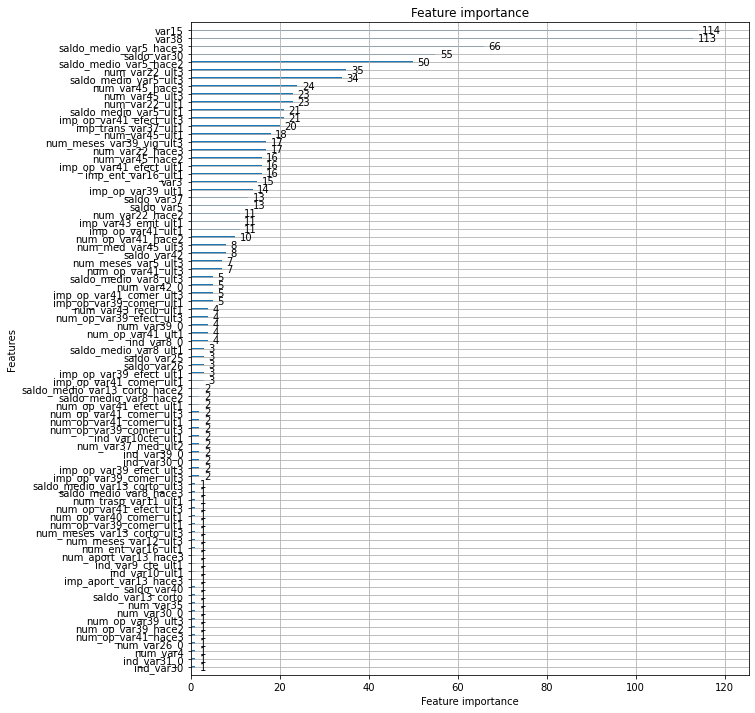

In [24]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_clf,ax=ax)